In [1]:
!pip install keras-tuner

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D

from keras.utils import plot_model
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras import layers

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [3]:
%load_ext autotime
RANDOM_STATE = 42

In [4]:
seed = 7
np.random.seed(seed)

time: 220 ms


In [5]:
MEMORY_LIMIT = 4500
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    except RuntimeError as e:
        print(e)

time: 1.66 s


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 64.3 ms


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

time: 7 s


In [8]:
tf.test.is_built_with_cuda()

True

time: 1.94 ms


In [9]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

time: 81.4 ms


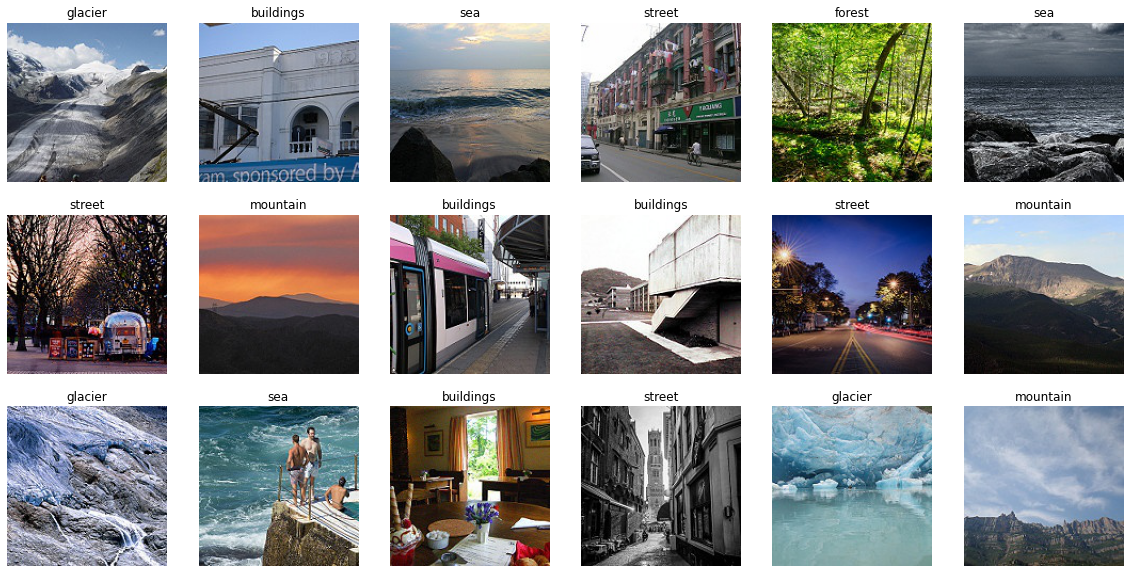

time: 1.55 s


In [10]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/',target_class=class_name)

In [11]:
train_dir = "/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/"
test_dir = "/home/anjir29/Desktop/America/data/archive/seg_test/seg_test/"
val_dir ="/home/anjir29/Desktop/America/data/archive/seg_val/seg_test/"

time: 484 µs


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
time: 597 ms


In [13]:
LOG_DIR = f"{int(time.time())}"

time: 529 µs


In [14]:
def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, padding = 'same',input_shape=(32, 32,3),activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu', 'tanh', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, activation=hp.Choice('activation_1',values=['relu', 'elu', 'gelu', 'selu'],default='relu'), padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    #####################################Block 2#################################         
    model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 3#################################            
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_3',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same',))
    model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_3',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 4################################
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 5#################################
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ############################################################################
    model.add(Dropout(hp.Choice('dp_size_6', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64),activation=hp.Choice('activation_dense',values=['relu', 'elu', 'gelu', 'selu'],default='relu'),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
    model.add(Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64),activation=hp.Choice('activation_dense',values=['relu', 'elu', 'gelu', 'selu'],default='relu'),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
    model.add(Dropout(hp.Choice('dp_size_7', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Dense(units=6, activation="softmax"))
 ##############################################################################           
    
    opt = Adam(lr=hp.Choice('learning_rate', values=[0.1,0.01, 0.001, 0.0001],default=0.01))
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                  optimizer=opt,
                                                  metrics=['accuracy'])
    return model

time: 144 ms


In [15]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR,
    project_name='RS_Vgg16_Intel')

tuner.search_space_summary()
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
tuner.search(training_data,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=30,
             batch_size=64,
             callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
             validation_data=validation_data)

tuner.results_summary()

with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

Trial 20 Complete [00h 03m 13s]
val_accuracy: 0.7112500071525574

Best val_accuracy So Far: 0.8395833373069763
Total elapsed time: 02h 02m 09s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1624337422/RS_Vgg16_Intel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer_size_1: 512
activation_2: elu
dp_size_1: 0.3
activation_1: gelu
layer_size_2: 256
dp_size_2: 0.2
layer_size_3: 64
activation_3: relu
dp_size_3: 0.2
layer_size_4: 128
activation_4: relu
dp_size_4: 0.0
layer_size_5: 32
activation_5: relu
dp_size_5: 0.5
dp_size_6: 0.2
dense_size_1: 64
activation_dense: relu
wd_size_1: 0.0001
dense_size_2: 64
dp_size_7: 0.2
learning_rate: 0.0001
Score: 0.8395833373069763
Trial summary
Hyperparameters:
layer_size_1: 512
activation_2: gelu
dp_size_1: 0.3
activation_1: elu
layer_size_2: 256
dp_size_2: 0.2
layer_size_3: 16
activation_3: relu
dp_size_3: 0.5
layer_size_4: 128
activation_4: gelu
dp_size_4: 0.1
layer_size_5: 64


In [16]:
new_model = tuner.get_best_hyperparameters()[0]

time: 580 µs


In [17]:
model = tuner.hypermodel.build(new_model)

time: 449 ms


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 512)       14336     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 512)       2359808   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       5

In [19]:
hist=model.fit(training_data,
      batch_size=64,
      epochs=100,
      validation_data=validation_data,
      callbacks=[my_callbacks])

Epoch 1/100
439/439 [==============================] - 46s 103ms/step - loss: 1.7602 - accuracy: 0.2118 - val_loss: 1.5750 - val_accuracy: 0.3408
Epoch 2/100
439/439 [==============================] - 45s 102ms/step - loss: 1.5449 - accuracy: 0.3302 - val_loss: 1.4556 - val_accuracy: 0.3925
Epoch 3/100
439/439 [==============================] - 44s 101ms/step - loss: 1.3800 - accuracy: 0.3675 - val_loss: 1.2824 - val_accuracy: 0.4458
Epoch 4/100
439/439 [==============================] - 45s 102ms/step - loss: 1.2668 - accuracy: 0.4373 - val_loss: 1.1834 - val_accuracy: 0.4829
Epoch 5/100
439/439 [==============================] - 45s 102ms/step - loss: 1.1875 - accuracy: 0.4885 - val_loss: 1.1017 - val_accuracy: 0.5337
Epoch 6/100
439/439 [==============================] - 45s 102ms/step - loss: 1.1271 - accuracy: 0.5343 - val_loss: 1.0155 - val_accuracy: 0.5983
Epoch 7/100
439/439 [==============================] - 45s 102ms/step - loss: 1.0576 - accuracy: 0.5852 - val_loss: 1.0745 -

In [25]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 0s 45ms/step - loss: 0.5884 - accuracy: 0.7812
time: 110 ms
